# Прогнозирование количества заказов такси на следующий час

**Цель исследования** - Разработка системы предсказания объема заказа.

**Датафрейм:** Исторические данные о заказах такси в аэропортах.

**План работы:**
1. Импорт данных.

2. Анализ и подготовка данных.

3. Обучение моделей.
 
4. Проверка данных на тестовой выборке.

## Импорт данных:

In [37]:
pip install statsmodels 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
#Загружу необходимые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings("ignore")

RND = 12345

In [39]:
# Загружу датасет с распознованием дат и формированием новых индексов:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [40]:
# Изучу датасет:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В датасете 4416 наблюдений. С 1 марта 2018 года по 31 август 2018 года.

In [41]:
# Проверю дф на пропуски:
display(data.isna().sum())

datetime      0
num_orders    0
dtype: int64

Отлично, пропусков нет.

In [42]:
# Проверка, что индекс монотонный:
print(data.index.is_monotonic_increasing)

True


In [43]:
data['datetime'] = pd.to_datetime(data['datetime'])

# Устанавливаем временной индекс на столбец 'datetime'
data.set_index('datetime', inplace=True)

# Теперь можно использовать метод resample
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Анализ данных:

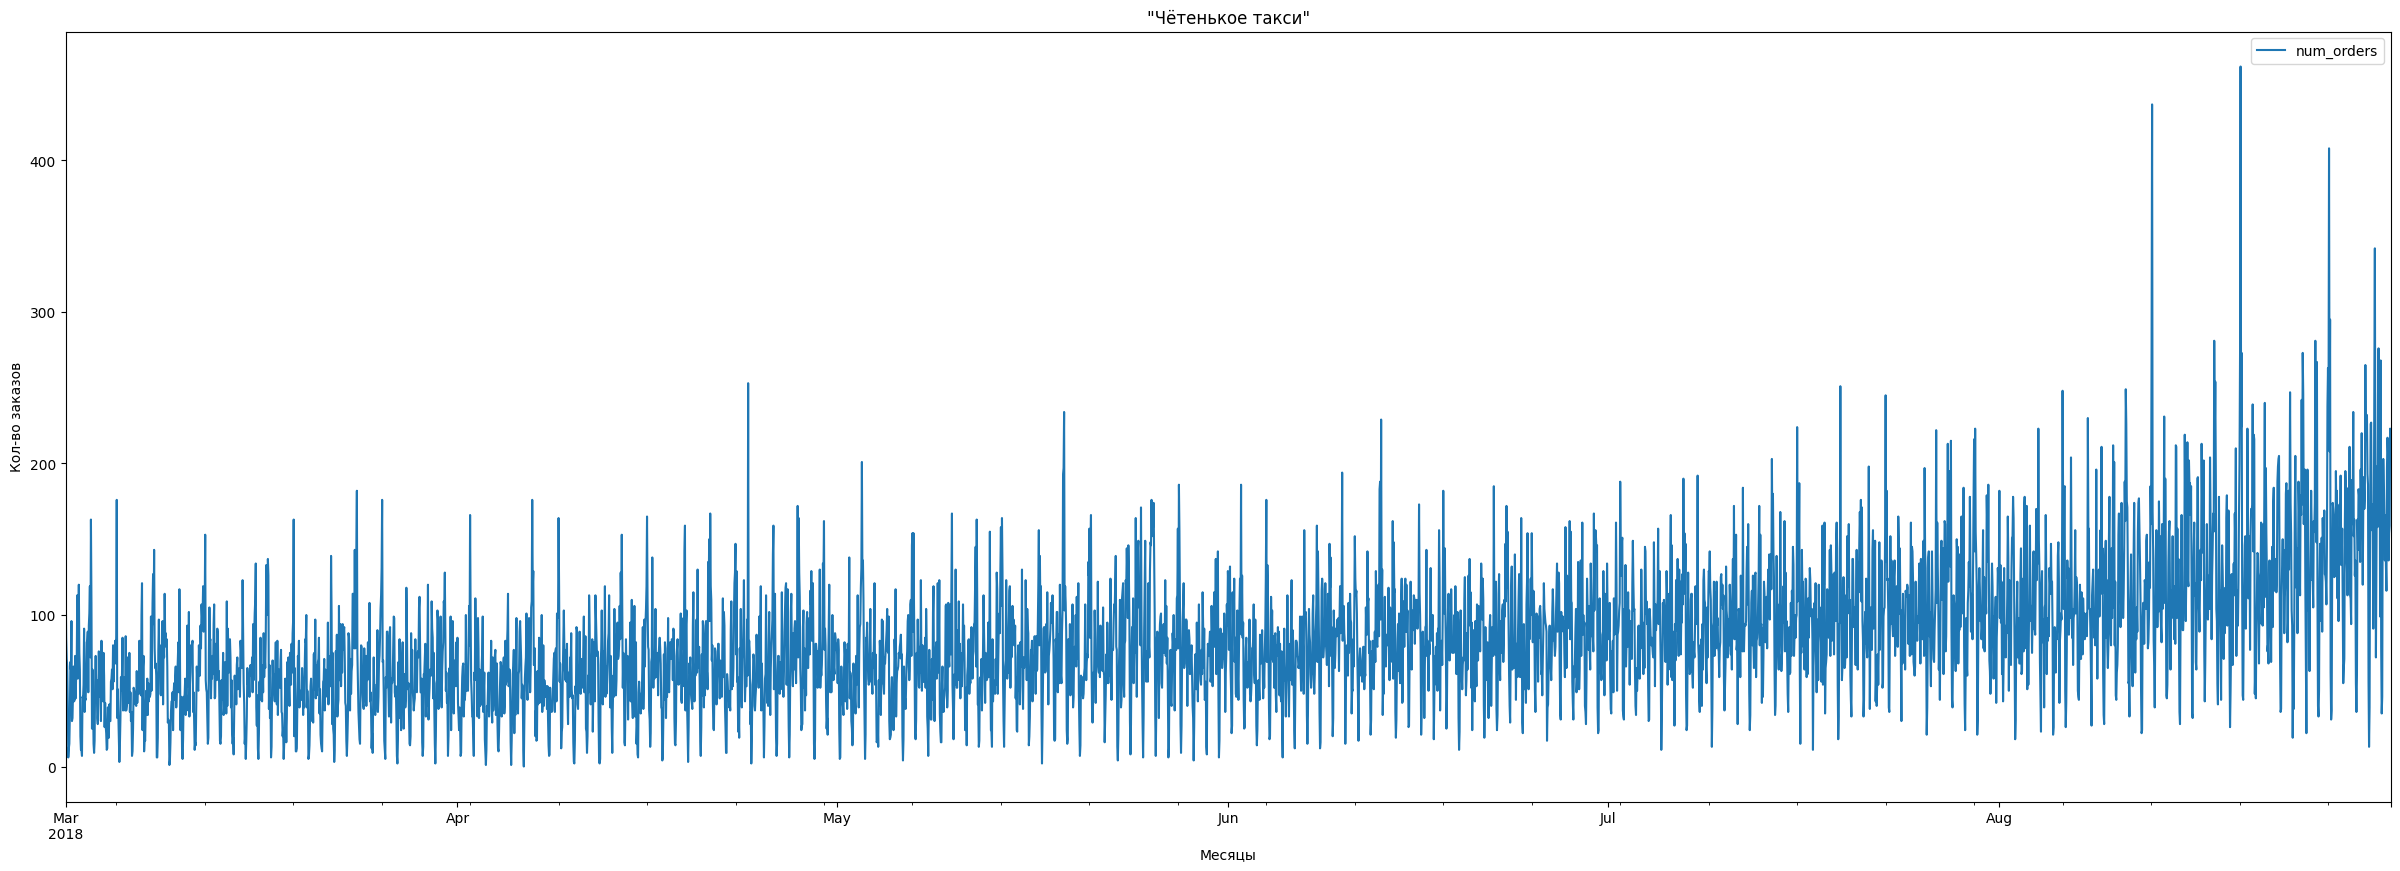

In [44]:
# Посмотрю на датасет в графике:
figsize = (30,10)
data.plot(figsize=figsize)
plt.title('"Чётенькое такси"')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Количество заказов постепенно повышается от марта к августу, но график непонятный, нужно с этим что-то сделать.

<Axes: xlabel='datetime'>

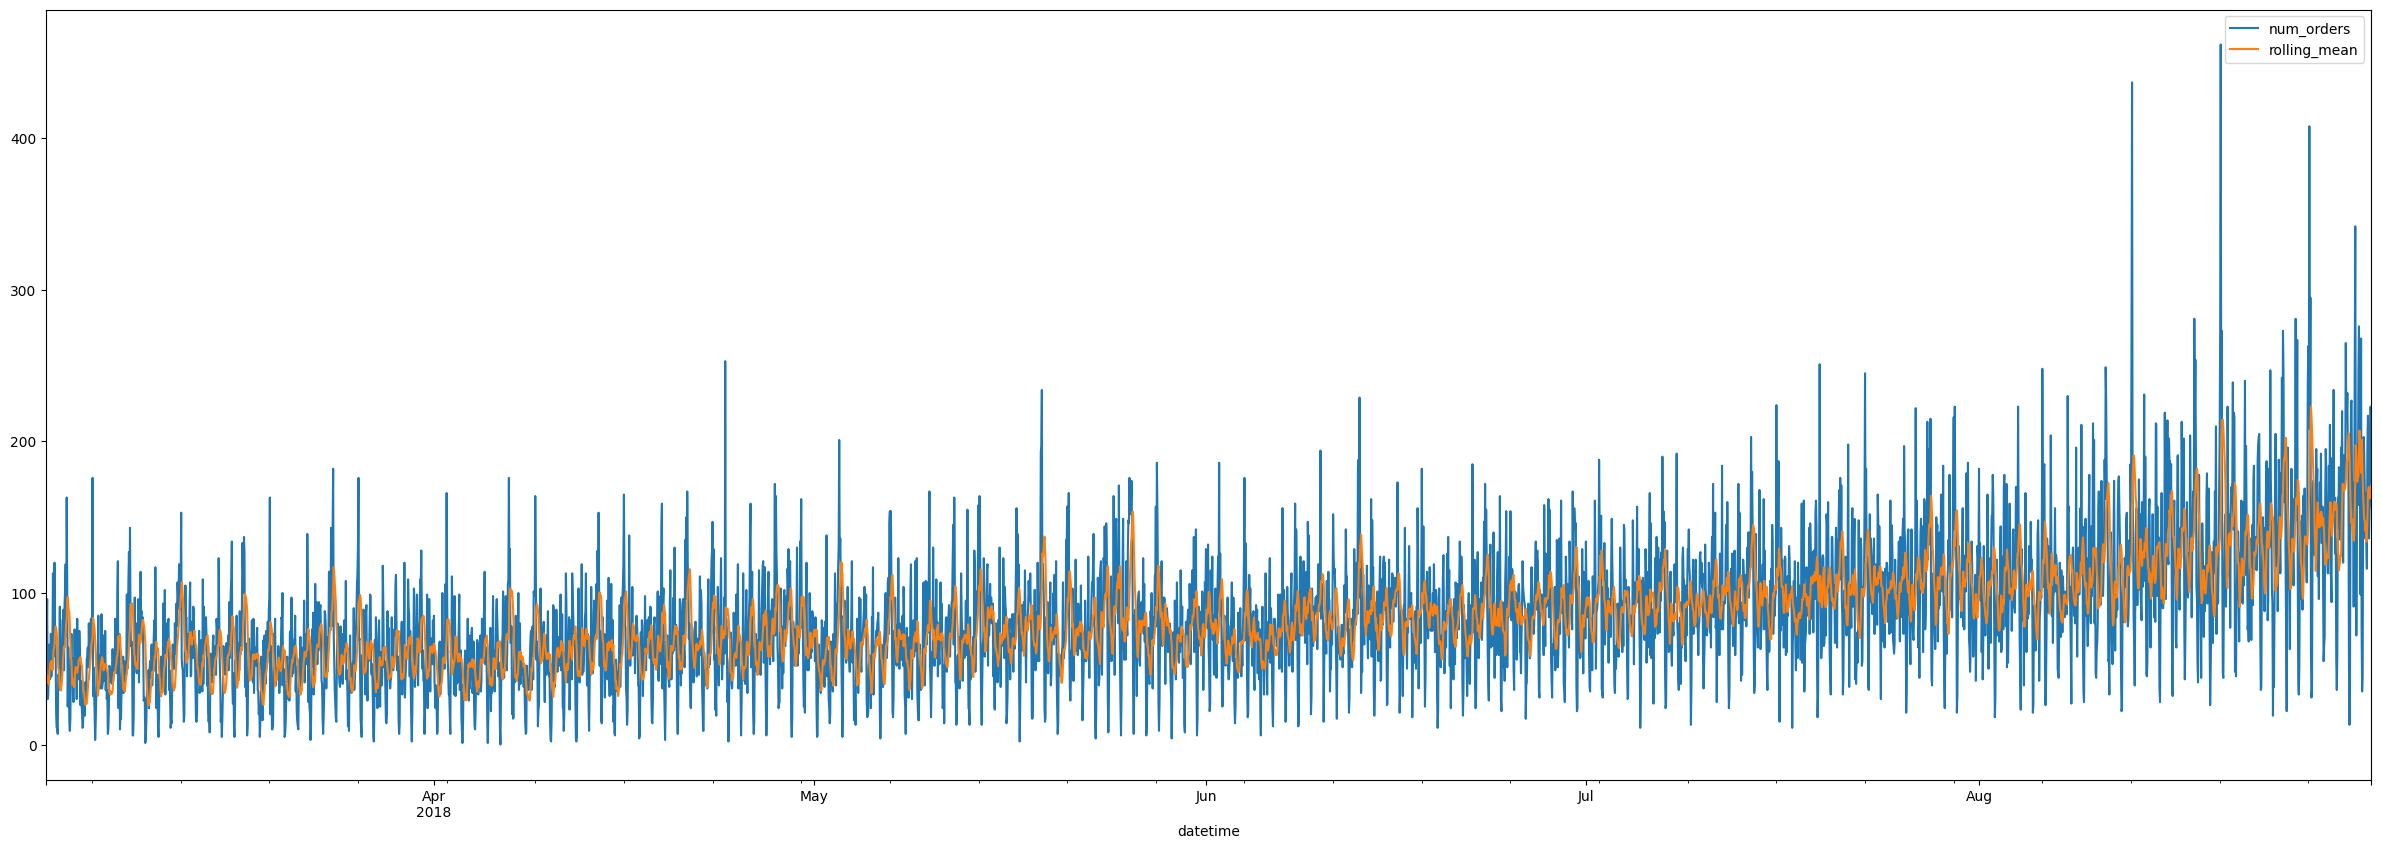

In [45]:
# Найдем значения, которые меньше всего подвержены колебаниям (т.е. скользящее среднее) 
df_mean = data.copy()
df_mean = df_mean.resample('1H').sum()
df_mean['rolling_mean'] = df_mean['num_orders'].shift().rolling(9).mean()
df_mean = df_mean.dropna()
df_mean[['num_orders', 'rolling_mean']].plot(figsize=figsize)

Среднее скользящее значение увеличивается, следовательно ряд нестационарный. 

### Декомпозиция:

Декомпозирую данные и посмотрю тренд и сезонность. Буду смотреть подробнее на август, так как это последний месяц в датасет.

In [46]:
# Декомпозирую данные:
decomposed = seasonal_decompose(data.num_orders)
# Новая переменная специально для августа:
data_aug = data['2018-08-01':]
decomposed_aug = seasonal_decompose(data_aug.num_orders)

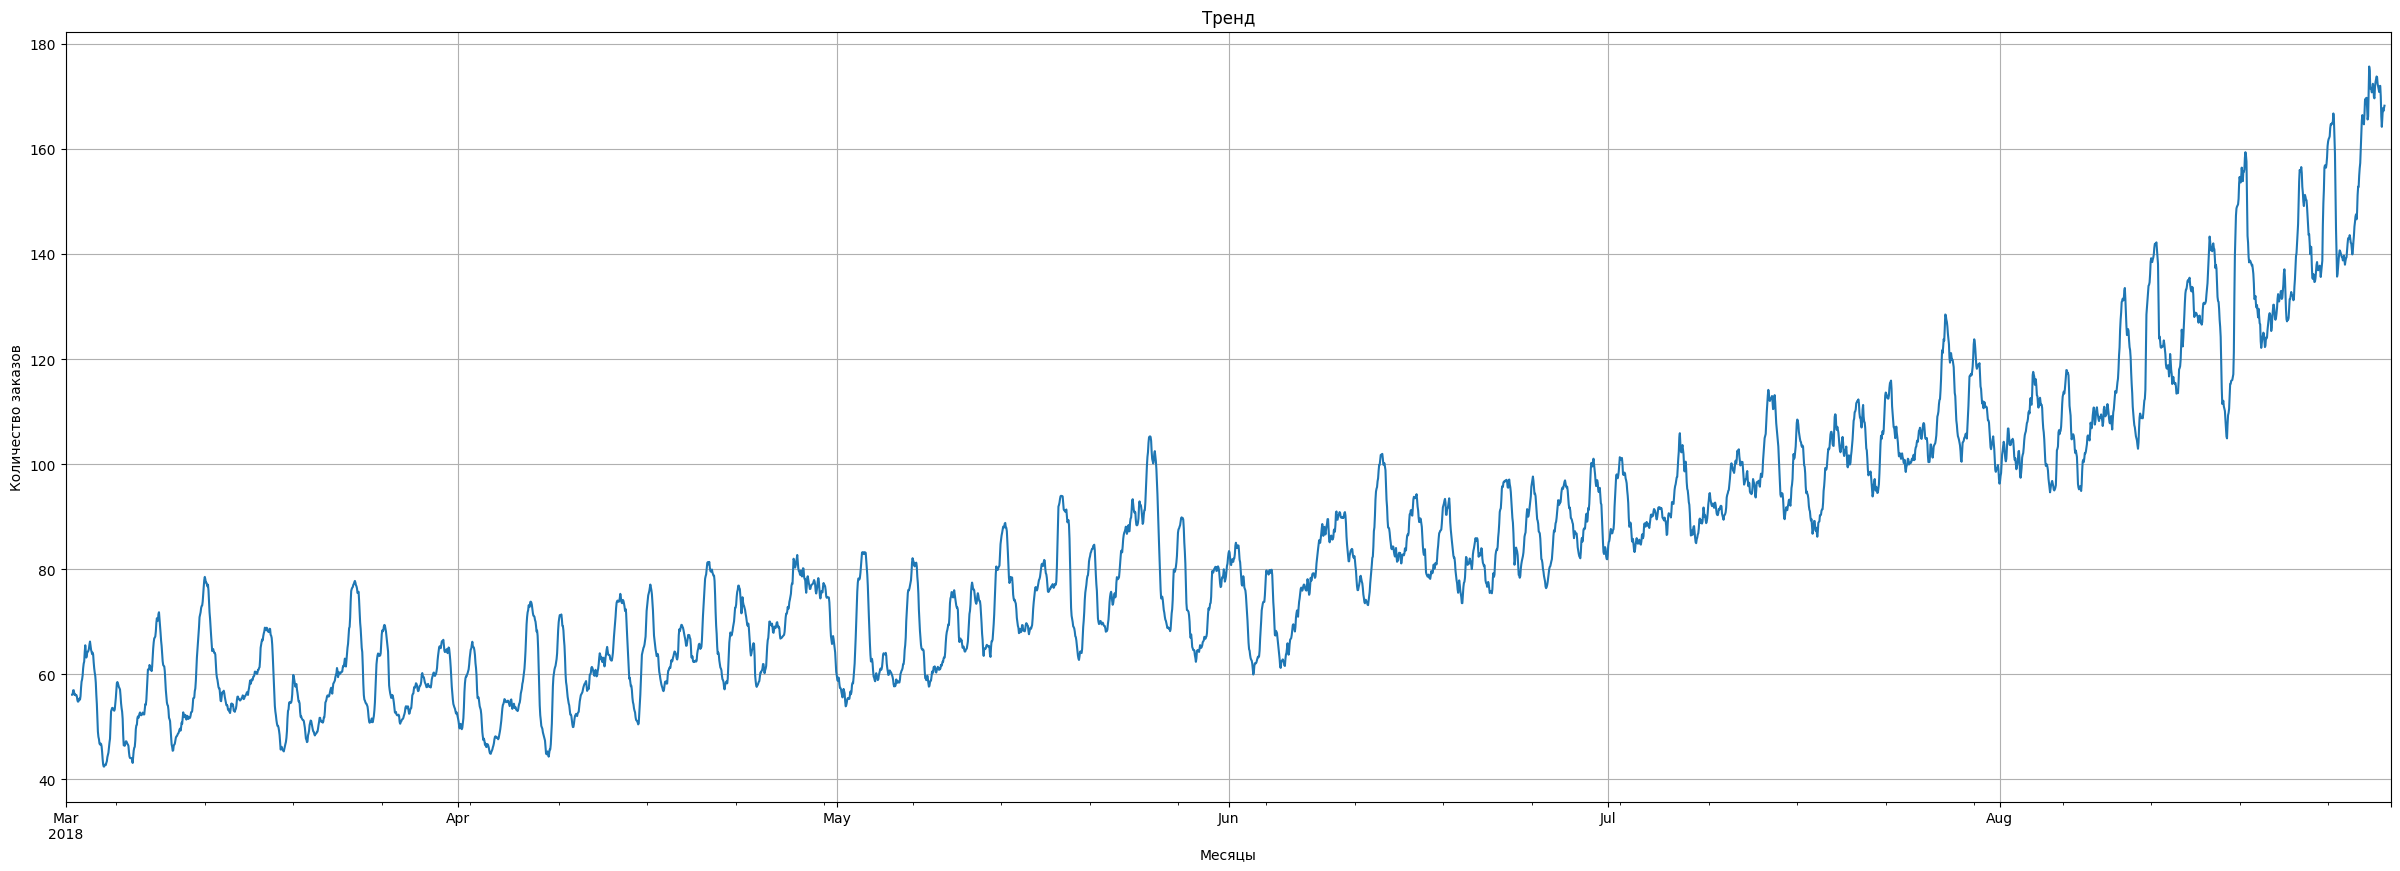

In [47]:
# Посмотри на тренд заказов:
decomposed = seasonal_decompose(data)

plt.figure(figsize=figsize)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Месяцы")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.show()

Действительно, есть тренд на увеличение количества заказов из месяца в месяц. 

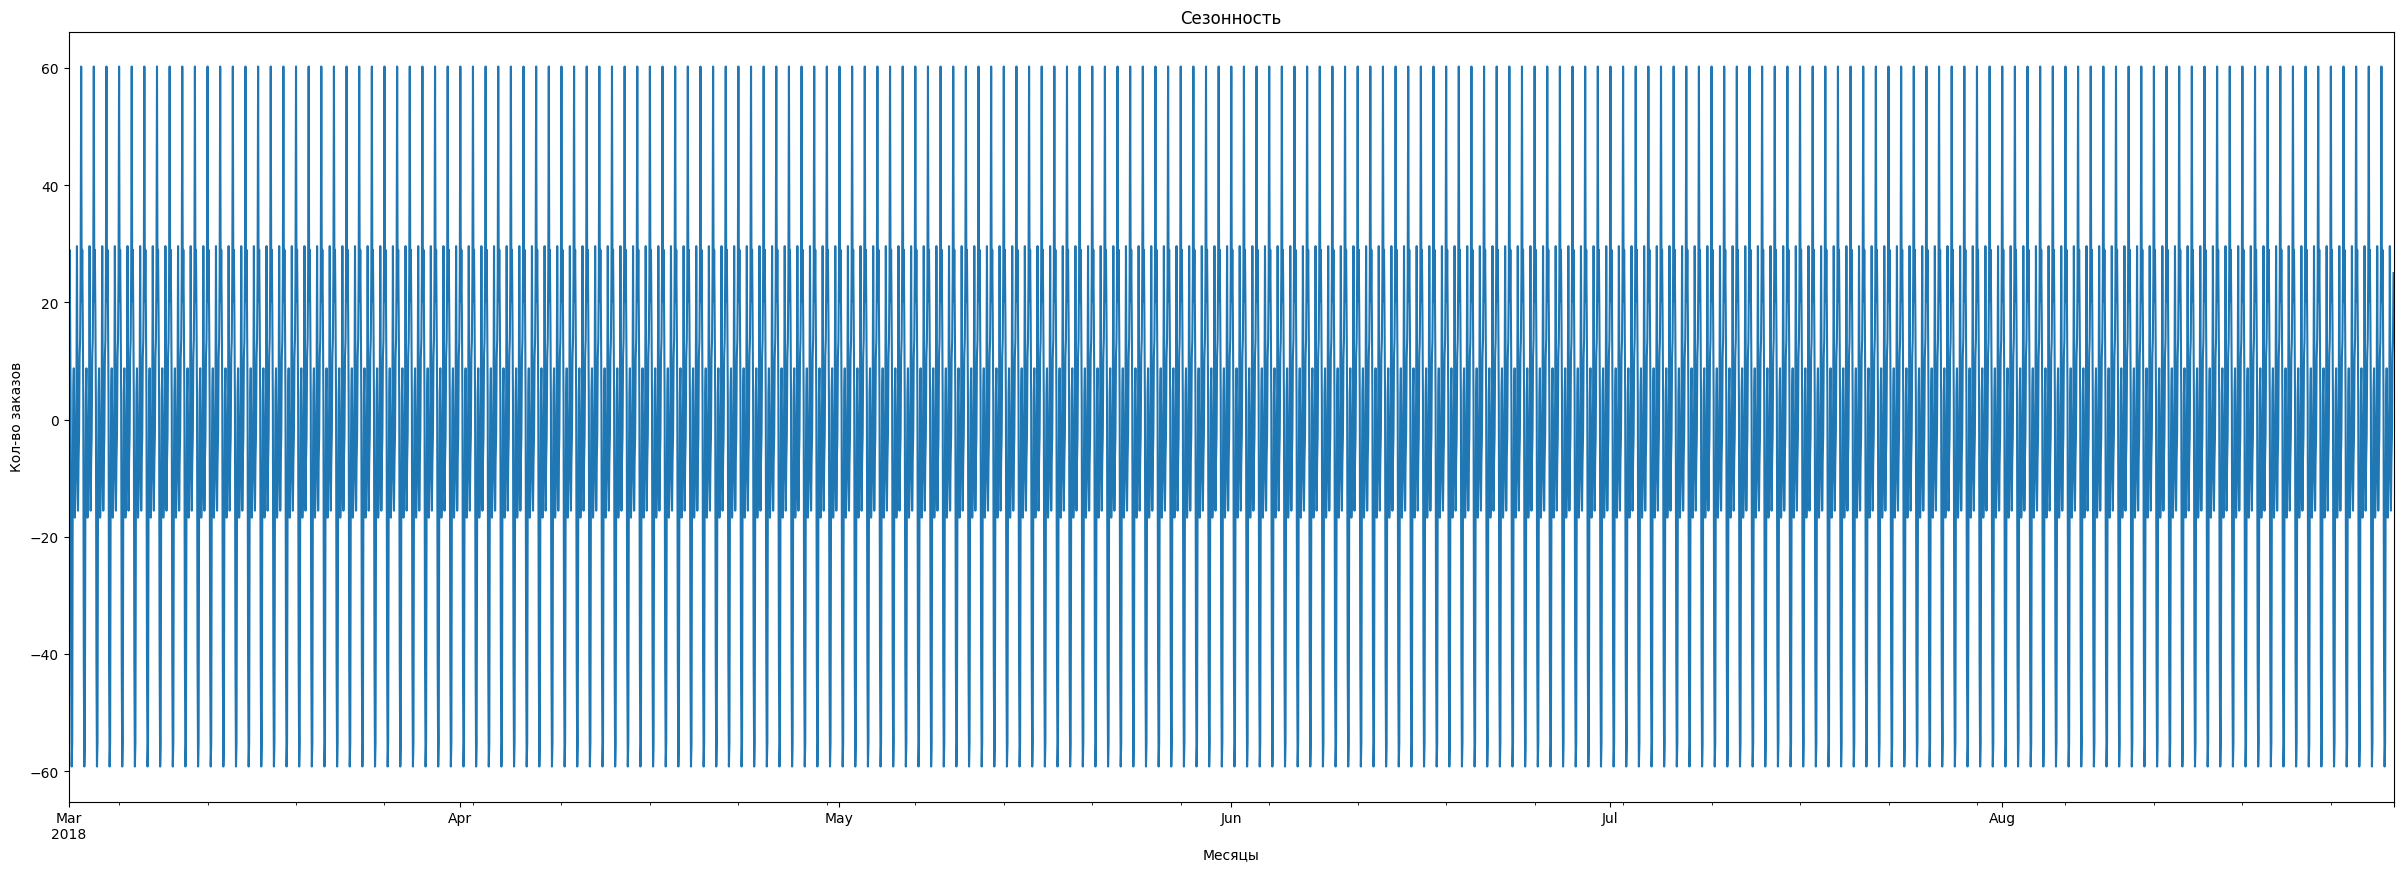

In [48]:
# Теперь посмотрим на сезонность: 
decomposed.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Посмотрим, что происходит в конкретный месяц:

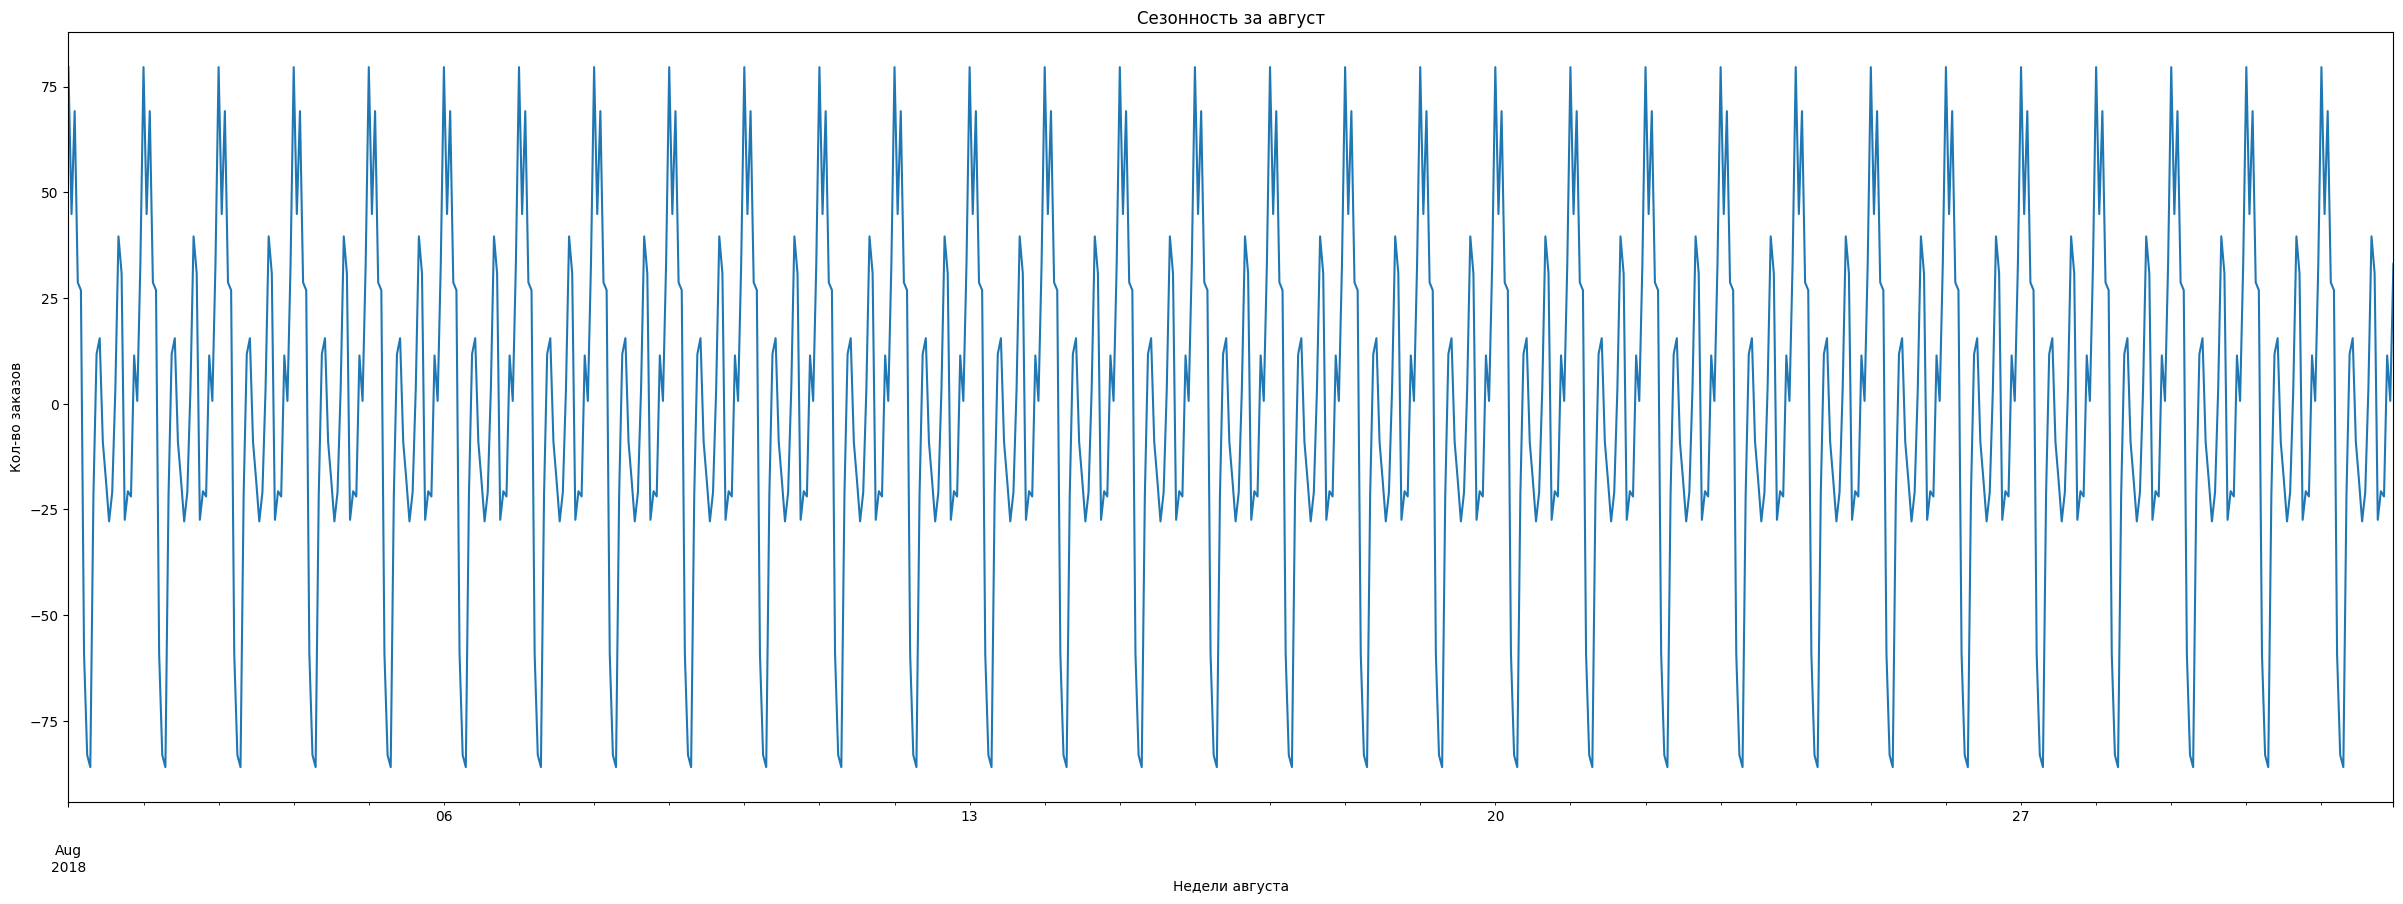

In [49]:
# Сезонность за август:
decomposed_aug.seasonal.plot(figsize=figsize)
plt.title('Сезонность за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

Посмотрим еще подробнее (сутки):

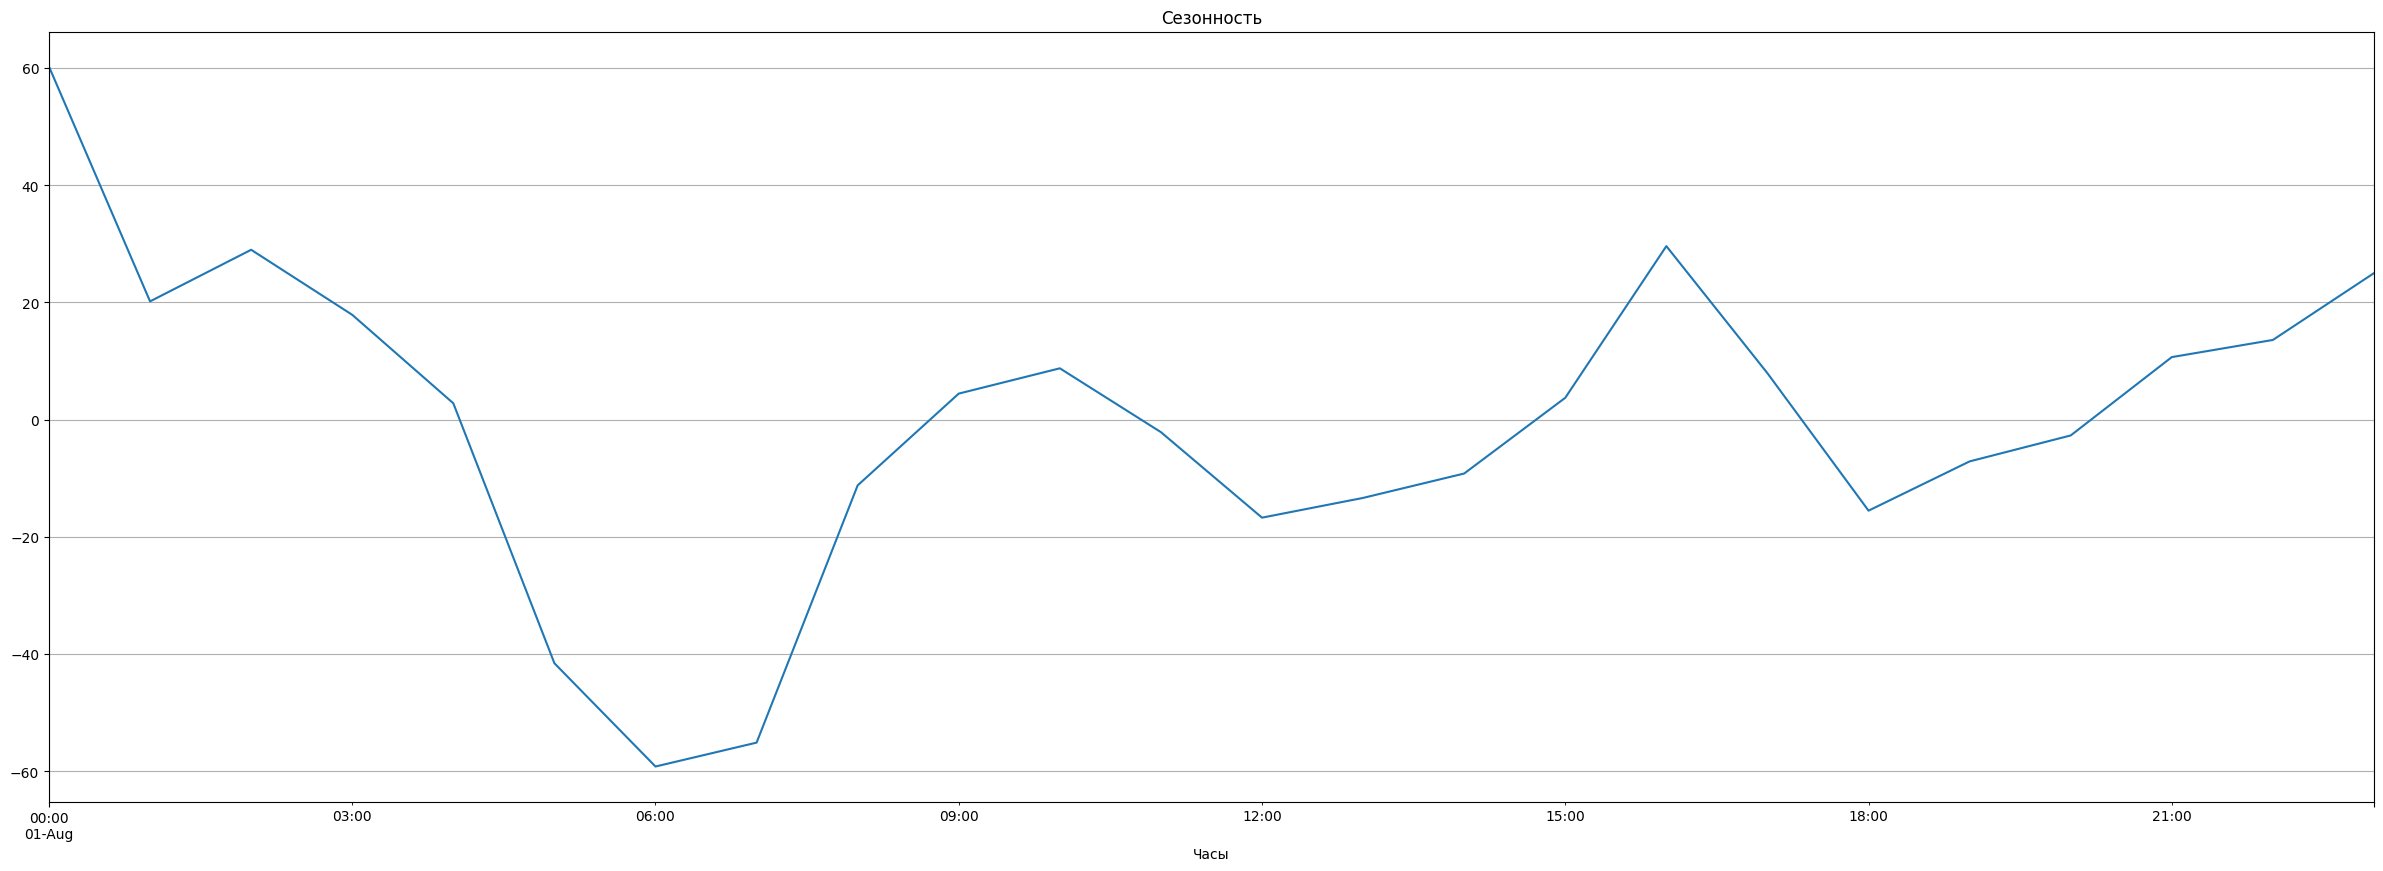

In [50]:
plt.figure(figsize=figsize)
decomposed.seasonal['2018-08-01':'2018-08-01'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Часы")
plt.grid(True)
plt.show()

Вывод: Сезонность - сутки. 
В 6.00, 12.00, 18.00 заказов в разы меньше, тогда как в 00.00, 10.00, 16.00 заказов максимум.

## Обучение моделей:

### 3.1 Создание фичей:

Создам фичи, для этого напишу фукнцию.Укажу максимальный размер отставания max_lag и окно для определения скользящего среднего - rolling_mean_size.

In [51]:
# Функция для создания фичей:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [52]:
make_features(data, 20, 20)
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,61,3,1,3,20,45.0,73.0,44.0,43.0,66.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.30
2018-03-01 21:00:00,66,3,1,3,21,61.0,45.0,73.0,44.0,43.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,50.15
2018-03-01 22:00:00,113,3,1,3,22,66.0,61.0,45.0,73.0,44.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,49.20
2018-03-01 23:00:00,58,3,1,3,23,113.0,66.0,61.0,45.0,73.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,51.30
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,50.90


In [53]:
# Поделю выборку, тестовая выборка 10% от исходных данных:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### 3.2 Обучение моделей на тренировочной выборке:

Обучу 3 модели: CatBoostRegressor, LinearRegression, LGBMRegressor.

In [54]:
# Подбоп гиперпараметров для CatBoostRegressor:
tsscv = TimeSeriesSplit(n_splits=round(train.shape[0] / test.shape[0] - 1))

catboost = CatBoostRegressor(loss_function='RMSE',random_state = RND)
parameters_cb = {'depth':[5, 10], 
                 'learning_rate':np.arange(0.1,1,0.2)} 
                 
gs_cb = catboost.grid_search(parameters_cb,
            Pool(features_train, target_train),cv=tsscv, verbose=True)

0:	learn: 72.6995279	test: 107.6471627	best: 107.6471627 (0)	total: 151ms	remaining: 2m 31s
1:	learn: 66.7571360	test: 101.3473022	best: 101.3473022 (1)	total: 155ms	remaining: 1m 17s
2:	learn: 61.4925341	test: 95.2871455	best: 95.2871455 (2)	total: 159ms	remaining: 52.8s
3:	learn: 56.9523158	test: 92.5564350	best: 92.5564350 (3)	total: 162ms	remaining: 40.3s
4:	learn: 52.7806104	test: 87.6257276	best: 87.6257276 (4)	total: 165ms	remaining: 32.8s
5:	learn: 49.1254638	test: 82.9813576	best: 82.9813576 (5)	total: 175ms	remaining: 29s
6:	learn: 45.8075207	test: 78.6635347	best: 78.6635347 (6)	total: 183ms	remaining: 25.9s
7:	learn: 43.0649553	test: 75.2570094	best: 75.2570094 (7)	total: 190ms	remaining: 23.5s
8:	learn: 40.4948508	test: 71.5446274	best: 71.5446274 (8)	total: 194ms	remaining: 21.4s
9:	learn: 38.4511973	test: 68.9721660	best: 68.9721660 (9)	total: 198ms	remaining: 19.6s
10:	learn: 36.2221594	test: 65.7648287	best: 65.7648287 (10)	total: 205ms	remaining: 18.4s
11:	learn: 34.4

In [55]:
# Обучу модель на лучших гиперпараметрах и посчитаю RMSE: 
model_cb = CatBoostRegressor(depth=gs_cb["params"]["depth"],
                             learning_rate=gs_cb["params"]['learning_rate'],
                             loss_function='RMSE',verbose=True)
                             
model_cb.fit(Pool(features_train, target_train), plot=True)
print('RMSE модели CatBoostRegressor на подобранных гиперпараметрах равна: = {:.2f}'.format(mse(target_train, model_cb.predict(features_train)) ** .5))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 34.4396165	total: 5.43ms	remaining: 5.43s
1:	learn: 31.1648224	total: 10.1ms	remaining: 5.06s
2:	learn: 29.5734482	total: 14.2ms	remaining: 4.72s
3:	learn: 28.3397580	total: 18.7ms	remaining: 4.65s
4:	learn: 26.6970760	total: 23.1ms	remaining: 4.6s
5:	learn: 25.8942564	total: 26.9ms	remaining: 4.46s
6:	learn: 25.4866910	total: 30.8ms	remaining: 4.37s
7:	learn: 24.7564250	total: 35.7ms	remaining: 4.42s
8:	learn: 24.2502890	total: 42.8ms	remaining: 4.71s
9:	learn: 23.9657667	total: 47.1ms	remaining: 4.66s
10:	learn: 23.7398525	total: 53.5ms	remaining: 4.81s
11:	learn: 23.6738921	total: 58.1ms	remaining: 4.79s
12:	learn: 23.2811785	total: 62.8ms	remaining: 4.76s
13:	learn: 23.2400339	total: 66.4ms	remaining: 4.67s
14:	learn: 23.0742474	total: 70.4ms	remaining: 4.62s
15:	learn: 22.9086244	total: 75.2ms	remaining: 4.63s
16:	learn: 22.8672085	total: 79.1ms	remaining: 4.57s
17:	learn: 22.8395582	total: 83.4ms	remaining: 4.55s
18:	learn: 22.7502439	total: 87.3ms	remaining: 4.5s
19:	l

In [56]:
# Обучу модель Линейной регрессии и посчитаю RMSE:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
print('RMSE модели CatBoostRegressor на подобранных гиперпараметрах равна: = {:.2f}'.format(mse(target_train, model_lr.predict(features_train)) **.5))

RMSE модели CatBoostRegressor на подобранных гиперпараметрах равна: = 28.97


In [57]:
# Напишу функцию для подбора гиперпараметров модели LGBMRegressor:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features_train, target_train)
    print('Лучшие гиперпараметры: ', grid_cv.best_params_)
    return grid_cv.best_params_

In [58]:
lgb_params = lgb_regr(features_train, target_train)

Лучшие гиперпараметры:  {'max_depth': 10, 'n_estimators': 100}


In [59]:
# Обучу модель на лучших гиперпараметрах и посчитаю RMSE: 
final_lgb = LGBMRegressor(max_depth=10, n_estimators=100)
final_lgb.fit(features_train, target_train, verbose=10, eval_metric='rmse')
predict_lgb = final_lgb.predict(features_train)
rmse_3 =mse(target_train, predict_lgb)**0.5
print('RMSE модели LightGBM на подобранных гиперпараметрах равна: = {:.2f}'.format(rmse_3))

RMSE модели LightGBM на подобранных гиперпараметрах равна: = 12.76


Лучшее RMSE получилась у модели CatBoostRegressor. Поверю на тестовой выборке.

## Проверка данных на тестовой выборке:

In [60]:
print('RMSE модели CatBoostRegressor на тестовых данных равна: = {:.2f}'.format(mse(target_test, model_cb.predict(features_test)) ** .5))

RMSE модели CatBoostRegressor на тестовых данных равна: = 44.37


Вывод: 
1. Я загрузила данные с распознованием дат и формированием новых индексов.
2.Изучила датасет, ресемплировала его по 1 чсу
3. Нашла скользящее среднее, и определила, что ряд нестационарный
4. Провела декомпозицию, и оценила тренд заказов и сезонности. Как вывод: тренд на увеличение от месяца к  месяцу. Сезонность - сутки. В 6.00, 12.00, 18.00 заказов в разы меньше, тогда как в 00.00, 10.00, 16.00 заказов максимум.
5. Создала фичи, написав функцию.
6. Поделила выборку трейн и тест, где тестовая выборка 10% от исходных данных.
7. Решила попробовать обучить трейн на CatBoostRegressor, LinearRegression, LGBMRegressor.
8. Лучший показатель RMSE на тренировочной выборке оказался у CatBoostRegressor (9.27).
9. После проверки на тестовой выборке этой модели RMSE меня также устроил (40.58) - "не больше 48". - значит модель CatBoostRegressor дает лучшие показатели.